In [1]:
%load_ext autoreload
%autoreload 2
import brian2hears as b2h
import brian2 as b2
from brian2 import Hz, kHz, second, Quantity,ms
from brian2hears import Sound, IRCAM_LISTEN
from consts import Paths
import numpy as np
import matplotlib.pyplot as plt


# sound exploration
start with plotting the hrtfed sounds, see the ITD, plot a spectrogram and the spectrum of a sound

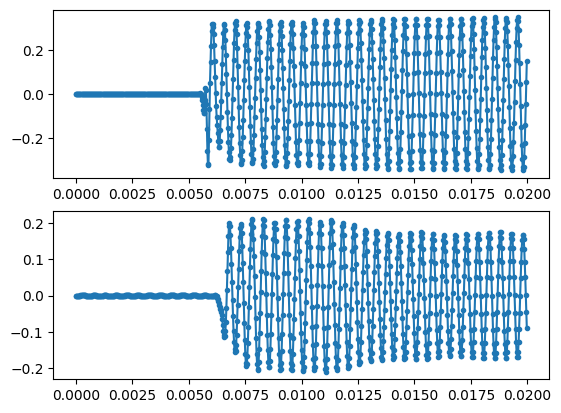

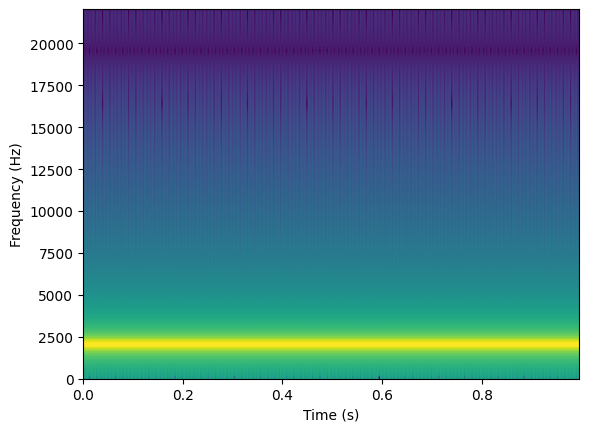

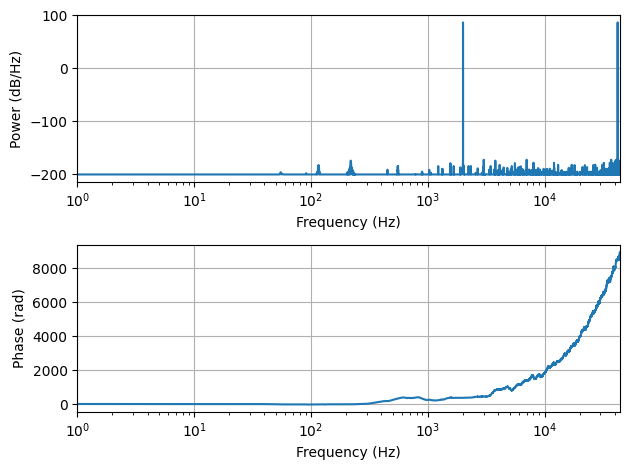

In [2]:
FREQ = 2 * kHz
SOUND_DURATION = 1 * second
sound: Sound = Sound.tone(FREQ, SOUND_DURATION)
# sound = sound.ramp()
hrtfdb = IRCAM_LISTEN(Paths.IRCAM_DIR)
hrtfset = hrtfdb.load_subject(hrtfdb.subjects[0])
# for angle in ANGLES:
# far left
hrtf = hrtfset(azim=90, elev=0)

binaural_sound: np.ndarray = hrtf.filterbank(sound).process().T
left = Sound(binaural_sound[0])
right = Sound(binaural_sound[1])

left_start = left[slice(0 * ms, 20 * ms)]
right_start = right[slice(0 * ms, 20 * ms)]
plt.subplot(211)
plt.plot(left_start.times, left_start, marker=".")
plt.subplot(212)
plt.plot(right_start.times, right_start, marker=".")
plt.show()

# sound_start = sound[slice(0*ms, 10*ms)]
# plt.plot(sound_start.times, sound_start, marker=".")
# plt.show()
sound.spectrogram()
plt.show()
x = sound.spectrum(display=True)
plt.show()


the brian2hears plot shows that its output isn't quite what we need, as it shows a spike at sampling frequency. let's learn how to do this ourselves. this is in `analyze/sound_analysis.py`

must calculate 2 things:
- ITD: interaural time difference: time difference between first value != 0 in each channel
- ILD: interaural level difference: level difference between channels: split by frequency; difference between frequency levels between the two channels, on the entire sound
    - for each side:
        - fft
        - fftshift
        - change x axis
        - take only positive side
    - diff the two 

### closest result from brian2hears spectrum

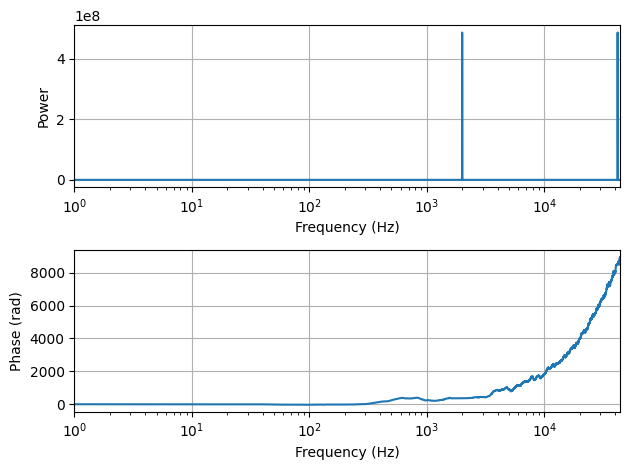

In [3]:
sound: Sound = Sound.tone(FREQ, SOUND_DURATION)

Z, freqs, phase = sound.spectrum(display=(True), log_power=False)
y = np.fft.fft(np.array(sound.flatten()))

# what i wrote

### ITD-ILD, single point
here is just the ITD and just ILD of a single frequency, for a single angle

2024-05-28 02:18:50,545 [INFO ]  

>>>>> start execution


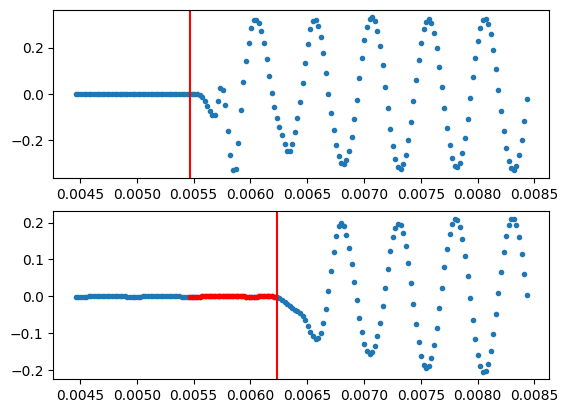

-0.77097506 ms


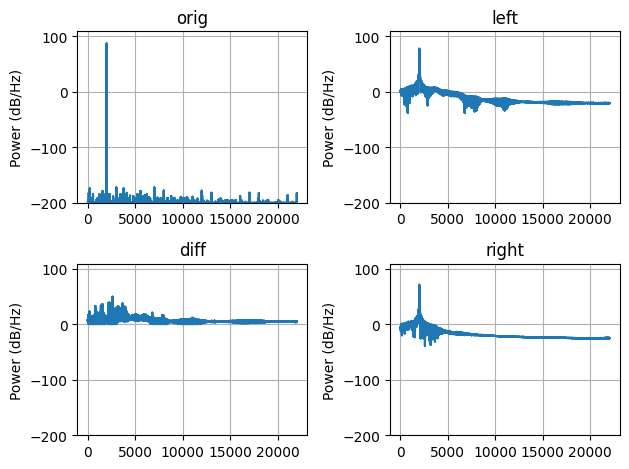

In [4]:
from analyze.sound_analysis import itd, ild
from utils.logging import logger
logger.setLevel(30)

FREQ = 2 * kHz
SOUND_DURATION = 1 * second
sound: Sound = Sound.tone(FREQ, SOUND_DURATION)
# sound = sound.ramp()
hrtfdb = IRCAM_LISTEN(Paths.IRCAM_DIR)
hrtfset = hrtfdb.load_subject(hrtfdb.subjects[0])
# far left
hrtf = hrtfset(azim=90, elev=0)

binaural_sound: np.ndarray = hrtf.filterbank(sound).process().T
left = Sound(binaural_sound[0])
right = Sound(binaural_sound[1])


print(itd(left, right, display=True))
_ = ild(left, right, sound, display=True)

there's a lot of noise in these plots.
- noise in original spectrum: remember that this plot is in logarithm, so the noise isn't actually that bad. also, numerical noise arises, so i hope this is where it comes from. i explored what the magnitude of numerical noise can be and how it varies in the appendix
- the diff has a lot of noise, even in frequencies that are not the pure tone! this is the result of the hrtf (i think), because i guess you get some echos while recording, in addition to the normal effects of pinna and auditory canal 

## plot complete ILDs and ITDS
here are the relevant plots: for 4 frequencies, here is how the hrtf affect them and what the ITDs and ILDS generated actually are.

IMPORTANT NOTE: i realized while making these plots that, even if i was using pure tones, the ILD isn't technically a single number, as different frequencies are affected differently, so it would be a vector of effects. because i had to collapse it down to a single value, i read the (Feddersen, 1957. Localization of High‐Frequency Tones, https://doi.org/10.1121/1.1909356), and it just said "on the axis of the boom carrying the loudspeaker.Thus for a single microphoneplacement and a single frequency we obtained a continuous record of level vs azimuth."
I decided that they probably only measured the pure tone level difference, so this is what i do with `angle_to_ild[angle] = full_ild[freqs == FREQ][0]`


In [5]:
FREQS = [0.2 * kHz, 1 * kHz, 3 * kHz, 6 * kHz]
hrtfdb = IRCAM_LISTEN(Paths.IRCAM_DIR)
hrtfset = hrtfdb.load_subject(hrtfdb.subjects[0])
SOUND_DURATION = 1 * second
ANGLES = [90, 75, 60, 45, 30, 15, 0, 345, 330, 315, 300, 285, 270]

old_to_new = {
    "90": -90,
    "75": -75,
    "60": -60,
    "45": -45,
    "30": -30,
    "15": -15,
    "0": 0,
    "345": 15,
    "330": 30,
    "315": 45,
    "300": 60,
    "285": 75,
    "270": 90,
}

for FREQ in FREQS:
    sound: Sound = Sound.tone(FREQ, SOUND_DURATION)
    # sound = sound.ramp()
    angle_to_ild = {}
    angle_to_itd = {}
    for angle in ANGLES:
        logger.info(f"now handling angle {angle}...")
        hrtf = hrtfset(azim=angle, elev=0)

        binaural_sound: np.ndarray = hrtf.filterbank(sound).process().T
        left = Sound(binaural_sound[0])
        right = Sound(binaural_sound[1])
        # left.spectrum(display=True)

        angle_to_itd[angle] = itd(left, right)
        full_ild, freqs = ild(left, right, sound)
        angle_to_ild[angle] = full_ild[freqs == FREQ][0]

    ilds = {}
    for angle, res in angle_to_ild.items():
        ilds[old_to_new[str(angle)]] = res

    itds = {}
    for angle, res in angle_to_itd.items():
        itds[old_to_new[str(angle)]] = res

    angles = list(ilds.keys())
    # plt.title(f"freq = {FREQ}")
    plt.subplot(211)
    plt.title(f"ILD freq = {FREQ}")
    plt.plot(angles, [ilds[angle] for angle in angles],  marker=".")
    plt.subplot(212)
    plt.title(f"ITD freq = {FREQ}")
    plt.plot(angles, [itds[angle] for angle in angles], marker=".")
    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.6, wspace=1)
    plt.show()

TypeError: 'tuple' object is not callable

# appendix

## is fft noisy?

is fft really as noisy as it looks? let's check some values
ws = 16384
std with ws = 16384 is 32.75379118559369


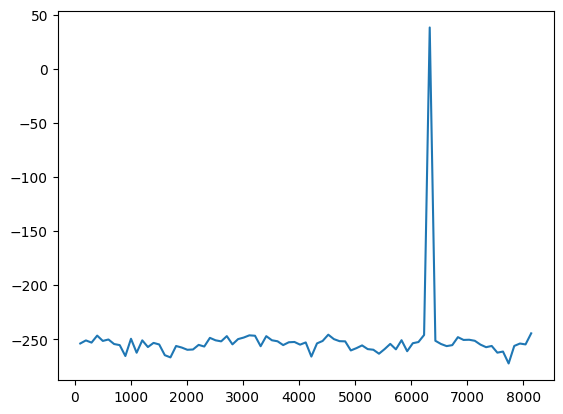

ws = 65536
std with ws = 65536 is 18.458956622966088


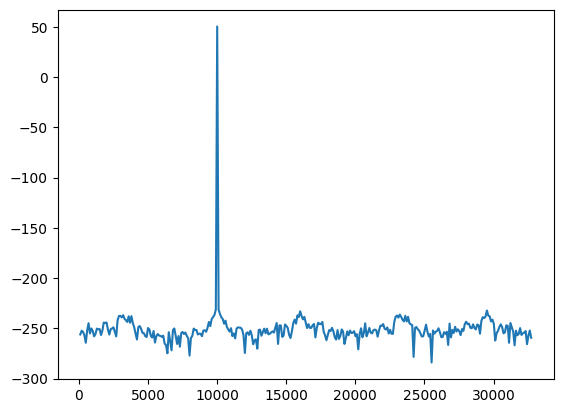

ws = 262144
std with ws = 262144 is 11.960813410230202


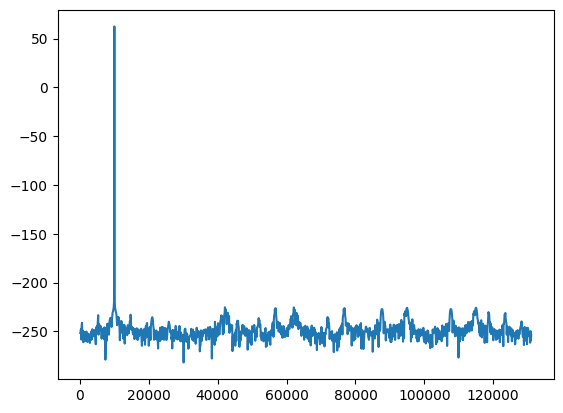

ws = 1048576
std with ws = 1048576 is 9.413160849135055


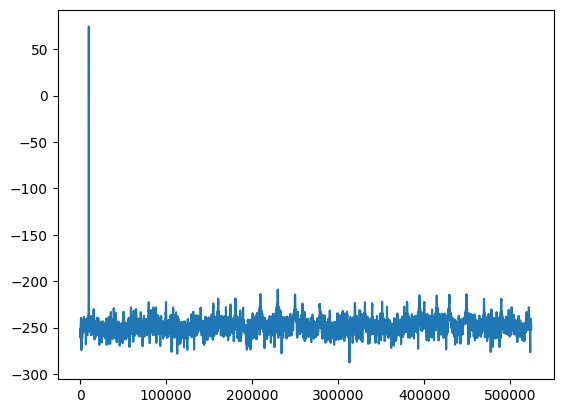

In [ ]:
print(f"is fft really as noisy as it looks? let's check some values")
for ws in [2**i for i in range(14, 22, 2)]:
    f = 10e3
    start = 0
    end = 100 * 1 / f
    print(f"ws = {ws}")
    N = int((end - start) * ws)
    t = np.linspace(start, end, N, endpoint=False)
    sign = np.sin(2 * np.pi * f * t)
    test_freq = np.fft.fftfreq(N, 1 / ws)
    test_sp = np.abs(np.fft.fft(sign))
    test_sp[test_sp < 1e-20] = 1e-20
    test_sp = 20 * np.log10(test_sp)
    test_sp = test_sp[test_freq > 0]
    test_freq = test_freq[test_freq > 0]
    print(f"std with ws = {ws} is {np.std(test_sp)}")
    plt.plot(test_freq, test_sp)
    plt.show()

## plot of effect of entire filterbank

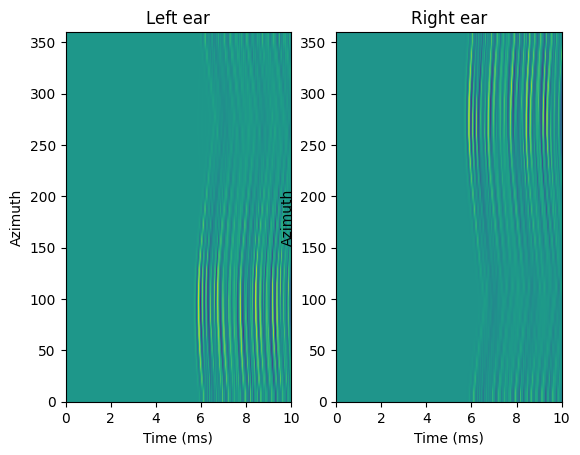

In [ ]:
# Load database
hrtfdb = IRCAM_LISTEN(Paths.IRCAM_DIR)
hrtfset = hrtfdb.load_subject(hrtfdb.subjects[0])
# Select only the horizontal plane
hrtfset = hrtfset.subset(lambda elev: elev==0)
# Set up a filterbank
sound = b2h.whitenoise(10*b2.ms)
fb = hrtfset.filterbank(sound)
# Extract the filtered response and plot
img = fb.process().T
img_left = img[:int(img.shape[0]/2), :]
img_right = img[int(img.shape[0]/2):, :]
plt.subplot(121)
plt.imshow(img_left, origin='lower', aspect='auto',
       extent=(0, sound.duration/ms, 0, 360))
plt.xlabel('Time (ms)')
plt.ylabel('Azimuth')
plt.title('Left ear')
plt.subplot(122)
plt.imshow(img_right, origin='lower', aspect='auto',
       extent=(0, sound.duration/ms, 0, 360))
plt.xlabel('Time (ms)')
plt.ylabel('Azimuth')
plt.title('Right ear')
plt.show()